# Actividad 3: Implementación de Redes Neuronales desde Cero
## Proyecto 5: Chatbot Conversacional - Clasificación de Intenciones

¡Bienvenidos! Este notebook contiene toda la implementación solicitada usando **solo NumPy**.

In [1]:
# Montar Google Drive (ejecutar solo la primera vez)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Cambiar al directorio del proyecto (ajusta el nombre de tu carpeta)
%cd '/content/drive/MyDrive/tarea-redes-neuronales-grupoX'
!mkdir -p data src notebooks results docs

[Errno 2] No such file or directory: '/content/drive/MyDrive/tarea-redes-neuronales-grupoX'
/content


## Parte 1: Implementación de la Red Neuronal Feedforward desde Cero

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

class NeuralNetwork:
    def __init__(self, layers, activation='relu', seed=42):
        np.random.seed(seed)
        self.layers = layers
        self.num_layers = len(layers)
        self.activation = activation
        self.weights = []
        self.biases = []

        for i in range(1, self.num_layers):
            if activation in ['sigmoid', 'tanh']:
                limit = np.sqrt(6 / (layers[i-1] + layers[i]))
                W = np.random.uniform(-limit, limit, (layers[i-1], layers[i]))
            else:  # ReLU → He
                std = np.sqrt(2 / layers[i-1])
                W = np.random.randn(layers[i-1], layers[i]) * std

            b = np.zeros((1, layers[i]))
            self.weights.append(W)
            self.biases.append(b)

    def _activate(self, z, derivative=False):
        if self.activation == 'sigmoid':
            sig = 1 / (1 + np.exp(-np.clip(z, -500, 500)))
            return sig if not derivative else sig * (1 - sig)
        elif self.activation == 'tanh':
            return np.tanh(z) if not derivative else 1 - z**2
        elif self.activation == 'relu':
            return np.maximum(0, z) if not derivative else (z > 0).astype(float)

    def forward(self, X):
        a = X
        activations = [X]
        z_values = []

        for i in range(self.num_layers - 2):
            z = a @ self.weights[i] + self.biases[i]
            a = self._activate(z)
            z_values.append(z)
            activations.append(a)

        # Capa salida con softmax
        z_out = a @ self.weights[-1] + self.biases[-1]
        exp_scores = np.exp(z_out - np.max(z_out, axis=1, keepdims=True))
        softmax = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        activations.append(softmax)

        self.activations = activations
        self.z_values = z_values + [z_out]
        return softmax

    def backward(self, X, y, output):
        m = X.shape[0]
        deltas = []

        # Delta salida (cross-entropy + softmax)
        delta = output - y
        deltas.append(delta)

        # Backprop ocultas
        for i in reversed(range(self.num_layers - 2)):
            delta = (delta @ self.weights[i+1].T) * self._activate(self.activations[i+1], derivative=True)
            deltas.append(delta)

        deltas.reverse()

        dW = []
        db = []
        for i in range(self.num_layers - 1):
            dW.append(self.activations[i].T @ deltas[i] / m)
            db.append(np.sum(deltas[i], axis=0, keepdims=True) / m)

        return dW, db

    def train(self, X, y, epochs=1000, learning_rate=0.01, verbose=True):
        losses = []
        accuracies = []

        for epoch in range(epochs):
            output = self.forward(X)
            loss = -np.mean(np.sum(y * np.log(output + 1e-15), axis=1))
            acc = np.mean(np.argmax(output, axis=1) == np.argmax(y, axis=1))

            losses.append(loss)
            accuracies.append(acc)

            dW, db = self.backward(X, y, output)

            for i in range(len(self.weights)):
                self.weights[i] -= learning_rate * dW[i]
                self.biases[i] -= learning_rate * db[i]

            if verbose and (epoch % 200 == 0 or epoch == epochs-1):
                print(f"Epoch {epoch:4d} | Loss: {loss:.4f} | Accuracy: {acc:.4f}")

        return losses, accuracies

## Parte 2: Datos Sintéticos para Clasificación de Intenciones

In [8]:
# Datos sintéticos de servicio al cliente (6 intenciones)
data = {
    'text': [
        "quiero cancelar mi pedido", "cancelar orden por favor", "anular compra",
        "hola buen día", "buenas tardes como estas", "saludo",
        "cuanto tarda el envio", "estado de mi pedido", "cuando llega mi paquete",
        "no recibí el producto", "me llegó dañado", "reclamo por envío",
        "cambiar dirección de entrega", "modificar domicilio", "actualizar dirección",
        "cuanto cuesta el producto", "precio del artículo", "cual es el costo"
    ],
    'label': [
        'cancelar_pedido', 'cancelar_pedido', 'cancelar_pedido',
        'saludo', 'saludo', 'saludo',
        'estado_envio', 'estado_envio', 'estado_envio',
        'reclamo', 'reclamo', 'reclamo',
        'cambiar_direccion', 'cambiar_direccion', 'cambiar_direccion',
        'consultar_precio', 'consultar_precio', 'consultar_precio'
    ]
}

df = pd.DataFrame(data)
df.to_csv('data/intent_data.csv', index=False)
df.head(10)

,text,label
0,quiero cancelar mi pedido,cancelar_pedido
1,cancelar orden por favor,cancelar_pedido
2,anular compra,cancelar_pedido
3,hola buen día,saludo
4,buenas tardes como estas,saludo
5,saludo,saludo
6,cuanto tarda el envio,estado_envio
7,estado de mi pedido,estado_envio
8,cuando llega mi paquete,estado_envio
9,no recibí el producto,reclamo


In [5]:
# Preprocesamiento: Bag of Words simple
def create_vocabulary(texts, max_vocab=100):
    words = ' '.join(texts).lower().split()
    most_common = Counter(words).most_common(max_vocab)
    vocab = {word: idx+1 for idx, (word, _) in enumerate(most_common)}
    return vocab

def text_to_bow(text, vocab):
    vec = np.zeros(len(vocab) + 1)
    for word in text.lower().split():
        if word in vocab:
            vec[vocab[word]] += 1
    return vec

vocab = create_vocabulary(df['text'])
X = np.array([text_to_bow(t, vocab) for t in df['text']])

labels = pd.Categorical(df['label']).codes
num_classes = len(set(labels))
y = np.eye(num_classes)[labels]

print(f"Vocabulario tamaño: {len(vocab)}")
print(f"Forma X: {X.shape}, Forma y: {y.shape}")

Vocabulario tamaño: 47
Forma X: (18, 48), Forma y: (18, 6)


## Parte 3: Experimentación Comparativa

In [6]:
results = []

architectures = [
    [X.shape[1], 64, 32, num_classes],
    [X.shape[1], 128, 64, num_classes],
    [X.shape[1], 256, 128, 64, num_classes]
]

activations = ['relu', 'tanh', 'sigmoid']
learning_rates = [0.01, 0.05, 0.1]

for arch in architectures:
    for act in activations:
        for lr in learning_rates:
            print(f"\n--- Arquitectura {arch} | Activación {act} | LR {lr} ---")
            model = NeuralNetwork(arch, activation=act)
            losses, accs = model.train(X, y, epochs=1000, learning_rate=lr, verbose=False)
            final_acc = accs[-1]
            results.append({
                'arquitectura': str(arch),
                'activacion': act,
                'lr': lr,
                'accuracy_final': final_acc,
                'loss_final': losses[-1]
            })
            print(f"Accuracy final: {final_acc:.4f}")

# Guardar resultados
results_df = pd.DataFrame(results)
results_df.to_csv('results/performance_comparison.csv', index=False)
results_df.sort_values('accuracy_final', ascending=False).head(10)


--- Arquitectura [48, 64, 32, 6] | Activación relu | LR 0.01 ---
Accuracy final: 1.0000

--- Arquitectura [48, 64, 32, 6] | Activación relu | LR 0.05 ---
Accuracy final: 1.0000

--- Arquitectura [48, 64, 32, 6] | Activación relu | LR 0.1 ---
Accuracy final: 1.0000

--- Arquitectura [48, 64, 32, 6] | Activación tanh | LR 0.01 ---
Accuracy final: 1.0000

--- Arquitectura [48, 64, 32, 6] | Activación tanh | LR 0.05 ---
Accuracy final: 1.0000

--- Arquitectura [48, 64, 32, 6] | Activación tanh | LR 0.1 ---
Accuracy final: 1.0000

--- Arquitectura [48, 64, 32, 6] | Activación sigmoid | LR 0.01 ---
Accuracy final: 0.3333

--- Arquitectura [48, 64, 32, 6] | Activación sigmoid | LR 0.05 ---
Accuracy final: 0.8889

--- Arquitectura [48, 64, 32, 6] | Activación sigmoid | LR 0.1 ---
Accuracy final: 1.0000

--- Arquitectura [48, 128, 64, 6] | Activación relu | LR 0.01 ---
Accuracy final: 1.0000

--- Arquitectura [48, 128, 64, 6] | Activación relu | LR 0.05 ---
Accuracy final: 1.0000

--- Arquitec

,arquitectura,activacion,lr,accuracy_final,loss_final
0,"[48, 64, 32, 6]",relu,0.01,1.0,0.113725
1,"[48, 64, 32, 6]",relu,0.05,1.0,0.004685
2,"[48, 64, 32, 6]",relu,0.10,1.0,0.001755
3,"[48, 64, 32, 6]",tanh,0.01,1.0,0.077314
4,"[48, 64, 32, 6]",tanh,0.05,1.0,0.006678
5,"[48, 64, 32, 6]",tanh,0.10,1.0,0.002832
8,"[48, 64, 32, 6]",sigmoid,0.10,1.0,0.462679
10,"[48, 128, 64, 6]",relu,0.05,1.0,0.003794
9,"[48, 128, 64, 6]",relu,0.01,1.0,0.049413
12,"[48, 128, 64, 6]",tanh,0.01,1.0,0.050904


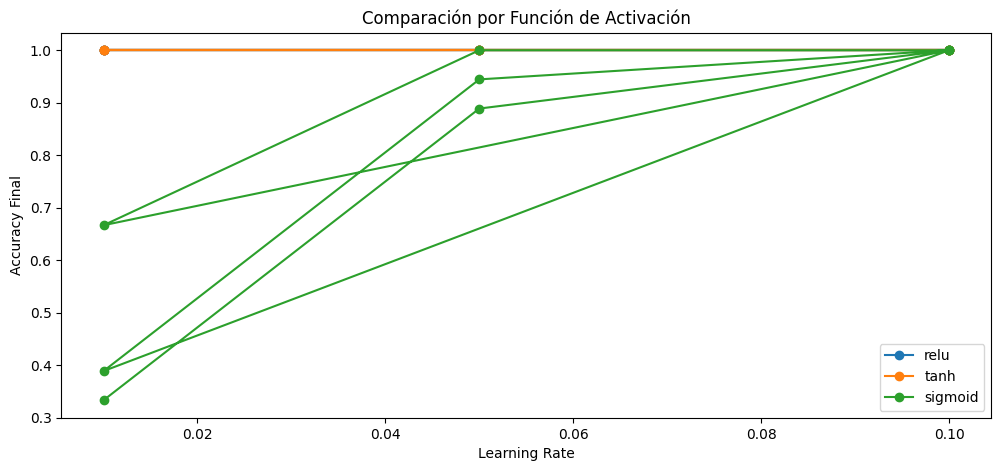

In [7]:
# Gráficas
plt.figure(figsize=(12,5))
for act in activations:
    subset = results_df[results_df['activacion'] == act]
    plt.plot(subset['lr'], subset['accuracy_final'], marker='o', label=act)
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy Final')
plt.title('Comparación por Función de Activación')
plt.legend()
plt.savefig('results/architecture_analysis.png')
plt.show()

## Parte 4: Análisis y Conexión con Proyecto Final

(Completa este texto en otro notebook o aquí mismo)